# Cas d'usage n°2

Après récupération d'un jeu de données quelconque (ici les 
marchés publics conclus recensés sur la plateforme des achats de l’Etat) 
retrouver les codes communes des attributaires connaissant les libellés 
communaux et les codes postaux.


In [1]:
import io
import numpy as np
import os
import pandas as pd
from requests_cache import CachedSession

from french_cities import find_city

## Récupération des marchés publics conclus

In [2]:
url = (
    "https://static.data.gouv.fr/"
    "resources/"
    "marches-publics-conclus-recenses-sur-la-plateforme-des-achats-de-letat/"
    "20160701-120733/Export_ETALAB_2015_complete.xlsx"
)
s = CachedSession()
r = s.get(url)
obj = io.BytesIO(r.content)
obj.seek(0)
df = pd.read_excel(obj)
for c in df.columns:
    try:
        df[c] = df[c].str.replace("^ *$", "", regex=True).replace("", None)
    except AttributeError:
        pass
df = df.dropna(how="all", axis=1)
print(f"Le dataframe est de forme {df.shape}")
df.head()

Le dataframe est de forme (10086, 12)


,Année de notification,Entité Publique,Entite d'achat,Nom Attributaire,SIRET Attributaire,Date de notification,Code Postal Attributaire,Ville,Nature du Marché,Objet du marché,Tranche budgetaire,Montant
0,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,SEDONA,42053121200033,2015-04-30,75009,PARIS 9,Services,Prestations d'assistance à la maitrise d'ouvra...,"50 000 HT à 89 999,99 HT","63 070,00"
1,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,ATOS CONSULTING,41033322300049,2015-01-21,75009,PARIS 9,Services,Etude à caractère prospectif des méthodes et o...,"90 000 HT à 124 999,99 HT","111 576,94"
2,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-029 - DGFI...,R.T.B. 56 ENTREPRISE GENERALE,52845802900014,2015-03-25,56850,CAUDAN,Travaux,Réorganisation de l'accueil et la mise aux nor...,"4 000 HT à 19 999,99 HT","19 346,95"
3,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 1 ...,"0 à 3 999,99 HT","2 000,00"
4,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 2 ...,"20 000 HT à 49 999,99 HT","37 000,00"


## Retraitement des codes postaux manifestement erronés

In [3]:
ix = df[
    ~df["Code Postal Attributaire"].fillna("").str.fullmatch("[0-9]{5}")
].index
df.loc[ix, "Code Postal Attributaire"] = np.nan

## Configuration de l'API INSEE

In [4]:
os.environ["insee_key"] = "********************"
os.environ["insee_secret"] = "********************"

## Reconnaissance des codes communes avec french-cities

In [5]:
df = find_city(
    df,
    year="last",
    x=False,
    y=False,
    epsg=False,
    city="Ville",
    dep=False,
    address=False,
    postcode="Code Postal Attributaire",
    use_nominatim_backend=True,
    field_output="codeInsee",
)
df.head()

,Année de notification,Entité Publique,Entite d'achat,Nom Attributaire,SIRET Attributaire,Date de notification,Code Postal Attributaire,Ville,Nature du Marché,Objet du marché,Tranche budgetaire,Montant,codeInsee
0,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,SEDONA,42053121200033,2015-04-30,75009,PARIS 9,Services,Prestations d'assistance à la maitrise d'ouvra...,"50 000 HT à 89 999,99 HT","63 070,00",75056
1,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / SG / SEP / SEP1 - Sous-Direction d...,ATOS CONSULTING,41033322300049,2015-01-21,75009,PARIS 9,Services,Etude à caractère prospectif des méthodes et o...,"90 000 HT à 124 999,99 HT","111 576,94",75056
2,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-029 - DGFI...,R.T.B. 56 ENTREPRISE GENERALE,52845802900014,2015-03-25,56850,CAUDAN,Travaux,Réorganisation de l'accueil et la mise aux nor...,"4 000 HT à 19 999,99 HT","19 346,95",56036
3,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 1 ...,"0 à 3 999,99 HT","2 000,00",53013
4,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,MPO FRANCE,41279837300012,2015-01-13,53700,AVERTON,Fournitures,Fournitures de supports numériques : lot n° 2 ...,"20 000 HT à 49 999,99 HT","37 000,00",53013


In [6]:
df.codeInsee.isnull().value_counts().to_frame("est vide")

,est vide
codeInsee,
False,9763
True,397


Examinons sommairement les lignes pour lesquelles les résultats sont absents (exclusion faite des cas où les communes ne sont pas même nommées dans le jeu de données) :

In [7]:
df[(df.codeInsee.isnull()) & (df.Ville.notnull()) & (~df.Ville.fillna("").str.match("-+"))]

,Année de notification,Entité Publique,Entite d'achat,Nom Attributaire,SIRET Attributaire,Date de notification,Code Postal Attributaire,Ville,Nature du Marché,Objet du marché,Tranche budgetaire,Montant,codeInsee
5,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,SYNOPTIC INTERNATIONAL,FR84000018357,2015-01-13,98000,Monaco,Fournitures,Fournitures de supports numériques : lot n° 3 ...,"0 à 3 999,99 HT","2 000,00",NaN
7,2015,Ministère des Finances et des Comptes publics ...,MFCP-MEIN / DGFIP / DGFIP-R / DGFIP-078 - DGFI...,SYNOPTIC INTERNATIONAL,FR84000018357,2015-01-13,98000,Monaco,Fournitures,Fournitures de supports numériques : lot n° 5 ...,"0 à 3 999,99 HT","500,00",NaN
1046,2015,Ministère de la Défense,MINDEF / Air / SIMMAD - Structure Intégrée de ...,LEVASUD,32047647600025,2015-01-27,NaN,SAINT JEANNET,Fournitures,Acquisition d'élingues NH90 de type DYNLEV20E...,"20 000 HT à 49 999,99 HT","46 704,00",NaN
1123,2015,Ministère de la Défense,MINDEF / EMA / DC SSA / DAPSA - Direction des ...,VECTEC,41324771900037,2015-05-11,NaN,HAUTERIVE,Fournitures,Fourniture d'agrafeuses et applicateurs de cli...,"20 000 HT à 49 999,99 HT","41 602,00",NaN
1441,2015,Ministère de la Défense,MINDEF / EMA / DC SSA / DAPSA - Direction des ...,Xstrahl,3105256,2015-12-23,NaN,"Camberley, Surrey",Fournitures,Acquisition d'une cabine auto-protégée d'irrad...,"193 000 HT à 999 999,99 HT","290 989,00",NaN
1801,2015,Union des Groupements d'Achats Publics,UGAP / DA / DA-SER - Département Services,GROUPE SERVICES FRANCE,77567529100428,2015-03-10,NaN,BIOT,Services,Prestations de propreté de locaux et de surfac...,"3 000 000 HT à 4 844 999,99 HT","3 411 636,00",NaN
1802,2015,Union des Groupements d'Achats Publics,UGAP / DA / DA-SER - Département Services,GROUPE SERVICES FRANCE,77567529100428,2015-03-10,NaN,BIOT,Services,Prestations de propreté de locaux et de surfac...,"3 000 000 HT à 4 844 999,99 HT","3 411 636,00",NaN
2146,2015,Ministère des Affaires étrangeres et du Dévelo...,None,FLYTRANS,33264094500066,2015-05-07,NaN,BIOT,Services,Affrétement d'un avion pour le Népal suite au ...,"193 000 HT à 999 999,99 HT","238 178,00",NaN
2849,2015,"Ministère de l'Environnement, de l'Énergie et ...",MEEM-MLDH / SD / DIR / DIR A - Direction Inter...,GEDIVEPRO,33990152200047,2015-10-06,NaN,SAINT VICTOR,Fournitures,Fourniture de vêtements de travail et d'équipe...,"193 000 HT à 999 999,99 HT","240 000,00",NaN
2850,2015,"Ministère de l'Environnement, de l'Énergie et ...",MEEM-MLDH / SD / DIR / DIR A - Direction Inter...,GEDIVEPRO,33990152200047,2015-10-06,NaN,SAINT VICTOR,Fournitures,Fourniture de vêtements de travail et d'équipe...,"193 000 HT à 999 999,99 HT","240 000,00",NaN


Il n'y a en réalité que 43 résultats absents (et même seulement 28 entrées uniques). Parmi ceux-ci, nous avons des communes étrangères, des fautes de frappe (par exemple, Grande-Synthe est dans le 59 et non le 56) et des communes insuffisamment décrites (pas de code postal).

💡Nota : pour aller un tout petit peu plus loin, notons que `french-cities` est tout à fait capable de retrouver une commune sans son code postal, mais à la seule condition qu'il n'y ait aucun homonyme sur le territoire national. En l'occurrence, il y a deux "Saint Jeannet" en France (dans les [Alpes-Maritimes](https://fr.wikipedia.org/wiki/Saint-Jeannet_(Alpes-Maritimes)) et dans les [Alpes de Haute-Provence](https://fr.wikipedia.org/wiki/Saint-Jeannet_(Alpes-de-Haute-Provence)))...

## Restitution graphique des principales communes représentées dans le jeu de données

In [8]:
df["Montant"] = pd.to_numeric(df["Montant"].str.replace(",", ".").str.replace(" ", ""))

[Text(0.5, 0, 'Commune siège des attributaires'),
 Text(0, 0.5, 'Montant (en euros)')]

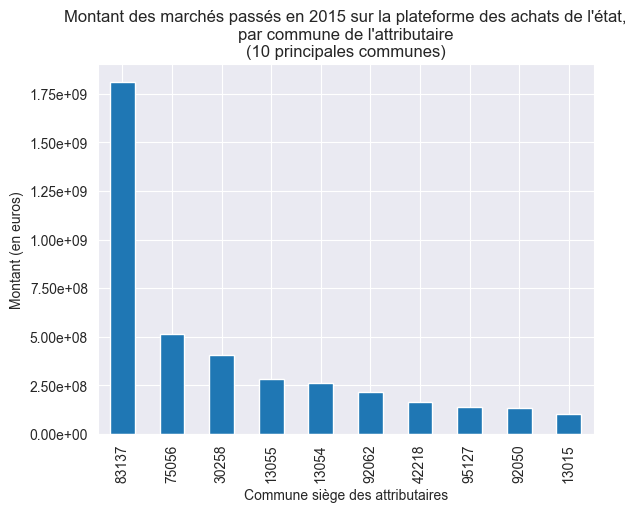

In [9]:
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_style("darkgrid")

ax = df.groupby("codeInsee")["Montant"].sum().sort_values(ascending=False).head(10).plot(
    kind="bar", 
    title="Montant des marchés passés en 2015 sur la plateforme des achats de l'état,\npar commune de l'attributaire\n(10 principales communes)",
)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
ax.set(xlabel="Commune siège des attributaires", ylabel="Montant (en euros)")